In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

In [2]:
from isaac.utils import plot_confusion_matrix
from isaac.dataset import read_dataset, prepare_dataset, normalise
from isaac.training import training_loop, evaluate
from isaac.models import RNNModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS

# Train models from scratch

In [3]:
# exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

TRAINING_FOR = "force"

if TRAINING_FOR == "force":
    class_columns = FORCE_CLASS_COLS
    # yoked_trials = exp1_trials + exp2_force_trials
    yoked_trials = exp1_trials
else:
    class_columns = MASS_CLASS_COLS
    # yoked_trials = exp1_trials + exp2_mass_trials
    yoked_trials = exp1_trials

## Train force model

In [4]:
train_loader, val_loader, scaler = prepare_dataset(exp2_mass_trials, FORCE_CLASS_COLS, 128, 
                                                   normalise_data=True, equiprobable_training_classes=False,
                                                  training_columns=YOKED_TRAINING_COLS)

100%|██████████| 400/400 [00:01<00:00, 325.44it/s]


In [5]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [6]:
counts

array([111, 112,  97])

In [7]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.35


In [8]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(YOKED_TRAINING_COLS)    # input dimension
hidden_dim = 20  # hidden layer dimension
n_layers = 3     # number of hidden layers
output_dim = 3   # output dimension
dropout = 0.5

model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim, dropout=dropout)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
model.train()

ComplexRNNModel(
  (lstm): GRU(23, 20, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=20, out_features=3, bias=True)
)

In [10]:
epoch_losses, epoch_accuracies, _ = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=500)

Train_loss (0.26)	 Train_acc (86.88)	 Val_acc (33.75):  38%|███▊      | 192/500 [02:32<04:01,  1.28it/s]

KeyboardInterrupt: 

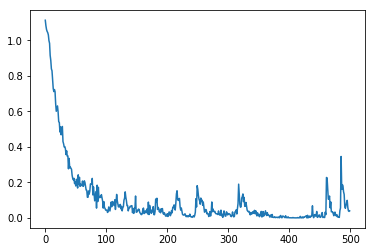

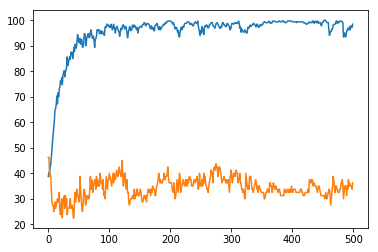

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)

## Train mass model

In [12]:
train_loader, val_loader, scaler = prepare_dataset(exp2_mass_trials, MASS_CLASS_COLS, normalise_data=True)

100%|██████████| 400/400 [00:00<00:00, 1142.76it/s]


In [13]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [14]:
counts

array([107,  99, 114])

In [15]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.35625


In [16]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
hidden_dim = 20  # hidden layer dimension
n_layers = 3     # number of hidden layers
output_dim = 3   # output dimension
dropout = 0.5

model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim, dropout=dropout)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
model.train()

ComplexRNNModel(
  (lstm): GRU(16, 20, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=20, out_features=3, bias=True)
)

In [18]:
epoch_losses, epoch_accuracies, _ = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=600)

Train_loss (1.07)	 Train_acc (41.88)	 Val_acc (33.75):   4%|▎         | 21/600 [00:08<03:50,  2.51it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)

In [ ]:
print(max(epoch_accuracies[1]))